# Run the whole deltas algorithm

In [1]:
%load_ext autoreload
%autoreload 2

import deltas
import numpy as np
from deltas.pipeline import data, classifier, evaluation
from deltas.classifiers.mnist_train import MNIST_torch, LargeMarginClassifier
from deltas.model import downsample, base
from tqdm import tqdm
from sklearn import datasets, metrics, svm

## Get data

In [2]:
binary = False
remove = []
remove = [2,3,4,5,6,7,8,9]
minority_id = [1]
split = 0.9
ratio = None
data_clf = data.get_real_dataset(
    'MNIST', scale=False, binary=binary, classes_remove=remove, minority_id=minority_id,
    split=split, ratio=ratio, equal_test=True)
X = data_clf['data']['X']
y = data_clf['data']['y']
# print(len(data_clf['data']['y']))
# print(sum(data_clf['data']['y']))
# import numpy as np
# print(np.unique(data_clf['data']['y']))
# deltas.plotting.plots.plot_classes(data_clf['data'], dim_reducer=data_clf['dim_reducer'])

12665 6742
MNIST: 12583
Number of attribues: 784
Classes total: 5923 - 6660

Classes train: 5330 - 6067
Classes test:  593 - 593


# Make sure data is correct

In [3]:
save_ims = False
if save_ims == True:
    # save data to folder local
    import matplotlib.image
    X = data_clf['data']['X']
    y = data_clf['data']['y']
    print(X.shape)
    print(y.shape)
    bs = 256
    num_splits = (len(y)//bs) + 1
    all_ids = np.arange(len(y))
    np.random.shuffle(all_ids)
    batch_ids = np.array_split(all_ids, num_splits)
    c = 0
    for i, batch in enumerate(batch_ids):
        ims = X[batch].reshape([len(batch), 1, 28, 28])
        target = y[batch]
        for j in range(len(batch)):
            im = np.squeeze(ims[j, :, :, :])
            matplotlib.image.imsave(f'./data/ims/{c}-{target[j]}.png', im)
            c += 1

In [4]:
# test can learn on an SVM
from sklearn.neural_network import MLPClassifier
clfs = [
    # svm.SVC(gamma=0.001), 
    # MLPClassifier(alpha=0, batch_size=256, learning_rate_init=0.001, verbose=True)
        ]
for clf in clfs:
    clf.fit(data_clf['data']['X'], data_clf['data']['y'])
    # test
    predicted = clf.predict(data_clf['data_test']['X'])
    print(
        f"Classification report for classifier {clf}:\n"
        f"{metrics.classification_report(data_clf['data_test']['y'], predicted)}\n"
    )

## Get Classifier

In [17]:

model = MNIST_torch
# model = LargeMarginClassifier
hots = len(np.unique(data_clf['data']['y']))
if hots == 2:
    hots = 1 # binary
clf = model(hots=hots, lr=0.001, cuda=True).fit(
    data_clf['data']['X'], data_clf['data']['y'], epochs=10)

clf.test(data_clf['data']['X'], data_clf['data']['y'], data_s='train')
clf.test(data_clf['data_test']['X'], data_clf['data_test']['y'], data_s='test')
clf.test_bal(data_clf['data']['X'], data_clf['data']['y'], data_s='train')
clf.test_bal(data_clf['data_test']['X'], data_clf['data_test']['y'], data_s='test')

train set: Accuracy: 0.9997367728349565
test set: Accuracy: 0.9991568296795953
train set: Balanced Accuracy: 0.9997527608373167
test set: Balanced Accuracy: 0.9991568296795953


# Output formats for deltas

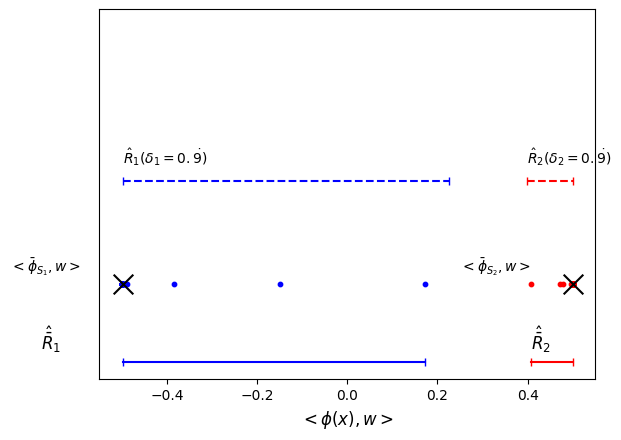

In [22]:
# check the projection to see if it makes any sense
X = data_clf['data_test']['X']
y = data_clf['data_test']['y']
base.base_deltas._plot_projection(X, y, clf)